# LSTMs forecast with considering feature selection (1-1, Multi-1, Multi-Multi)

### 1) Prepare Dataset
　　－　Imputation dataset (from the gap filling result by '202105_Fill_gap_with_LRTC-TNN_all para-include_tempre.ipynb'  
　　－　3 buoys '2010-01-02 00:00:00' - '2019-12-30 23:30:00' with no NaN value, totally 175200 rows x 21 columns  
　　－　Degree transfer to sin & cos which can be reversed back to degree
### 2) Model Variables
　　－　taget_feature_FS, target_feature, n_past, n_future
### 3) Feature Selection (ElasticNetCV)
　　－　Reasons of choosing ElasticNetCV see the Jupyter Notebook '202105_Feature_Selection_Experiments.ipynb'
### 4) Generate training dataset (MinMax Normalization)
　　－　Train on table[:6000], test on table[6000:7200]
### 5) Generate Model
　　－　**No feature selection LSTM 1-to-1:** build_model_LSTM_1_1buoy(train, n_past, n_future, FS_order)  
　　－　**No feature selection LSTM all-to-1:** build_model_LSTM_1buoy(train, n_past, n_future, FS_order)  
　　－　<font color='red'>**LSTM with feature selection: build_model_LSTM_FS_1buoy(train, n_past, n_future, FS_order)**</font>   
　　－　**Seq2Seq:** build_model_StackedLSTM_FS_1buoy(train, n_past, n_future, FS_order)  
　　－　**2StackedSeq2Seq:** build_model_2StackedLSTM(train, n_past, n_future, FS_order)  
　　－　**LSTM Dirp transformation only:** build_model_LSTM_FS_Dirp(train, n_past, n_future, FS_order)  
　　－　**Next** ===> Conditional LSTM considering ERA5 using cond_rnn: https://github.com/philipperemy/cond_rnn/  


### General Conclusions:　
　　1) Feature selection can improve the accuracy and efficiency of forecast  
　　2) LSTM performs equivalent to Seq2Seq and 2-stacked-Seq2Seq with same layer number  
　　3) Dirp transformation to sin cos can get equivalent accuracy than forecast on degree. But it has a drawback that sometimes the regressive cos_x might get values less than -1 which makes it invalid. When updating the transfer function, the prediction accuracy decreases. Therefore, Dirp transformation in the sin & cos way is not necessary.  

In [2109]:
# multivariate multi-step data preparation
from numpy import array
from numpy import hstack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
import pydot

In [2110]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense, Input, Activation, Flatten, Convolution1D, Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Attention
from tensorflow.keras.utils import plot_model

In [2111]:
import os
os.environ["PATH"] += ";C:/Program Files (x86)/Graphviz2.38/bin"

In [2112]:
import keras
print(keras.__version__)

2.5.0


In [2113]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import datetime
from sklearn.preprocessing import MinMaxScaler

In [2114]:
import pickle
def save(fname, data, protocol=3):
    with open(fname, "wb") as f:
        pickle.dump(data, f, protocol)

def load(fname):
    with open(fname, "rb") as f:
        return pickle.load(f)

In [2115]:
def cal_RMSE(origin, pred):
    mse = np.average((pred-origin)**2)
    rmse = np.sqrt(mse)

    return rmse

# def cal_MAPE(origin, pred):
#     from sklearn.metrics import mean_absolute_percentage_error as MAPE
#     return MAPE(origin, pred)

# 1) Prepare Dataset

In [2116]:
table = load('Fill_Gap/Imputed_Measurement')
table.columns = ['1Wave Height (m)', '1Max Wave Height (m)', '1Tpeak (s)', '1Tz (s)',
       '1Peak Direction (degrees)', '1Spread (degrees)', '1Sea Temp (C)',
       '2Wave Height (m)', '2Max Wave Height (m)', '2Tpeak (s)', '2Tz (s)',
       '2Peak Direction (degrees)', '2Spread (degrees)', '2Sea Temp (C)',
       '3Wave Height (m)', '3Max Wave Height (m)', '3Tpeak (s)', '3Tz (s)',
       '3Peak Direction (degrees)', '3Spread (degrees)', '3Sea Temp (C)']
table

,1Wave Height (m),1Max Wave Height (m),1Tpeak (s),1Tz (s),1Peak Direction (degrees),1Spread (degrees),1Sea Temp (C),2Wave Height (m),2Max Wave Height (m),2Tpeak (s),...,2Peak Direction (degrees),2Spread (degrees),2Sea Temp (C),3Wave Height (m),3Max Wave Height (m),3Tpeak (s),3Tz (s),3Peak Direction (degrees),3Spread (degrees),3Sea Temp (C)
Time (GMT),,,,,,,,,,,,,,,,,,,,,
2010-01-02 00:00:00,0.41,0.53,10.5,6.8,188.0,16.0,8.1,0.58,0.77,13.3,...,201.0,15.0,9.0,0.52,0.94,10.5,4.0,283.0,27.0,9.0
2010-01-02 00:30:00,0.37,0.59,11.1,6.3,187.0,10.0,8.2,0.52,0.79,11.1,...,208.0,19.0,9.1,0.54,0.79,4.8,4.1,316.0,42.0,9.1
2010-01-02 01:00:00,0.38,0.55,12.5,6.8,184.0,9.0,8.1,0.52,0.84,11.1,...,215.0,19.0,9.0,0.53,0.74,10.0,4.2,280.0,31.0,9.0
2010-01-02 01:30:00,0.38,0.59,11.8,7.0,184.0,12.0,8.2,0.51,0.81,12.5,...,203.0,14.0,9.0,0.56,0.80,4.4,4.1,326.0,49.0,9.0
2010-01-02 02:00:00,0.39,0.51,11.1,7.3,190.0,11.0,8.3,0.48,0.63,10.5,...,212.0,15.0,9.0,0.57,0.89,10.0,4.2,290.0,22.0,8.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 21:30:00,0.72,1.23,5.0,4.3,184.0,19.0,10.5,0.89,1.08,10.0,...,205.0,14.0,10.9,1.27,1.96,11.8,6.6,290.0,28.0,10.6
2019-12-30 22:00:00,0.71,1.03,5.3,4.3,186.0,23.0,10.5,0.85,1.40,11.1,...,211.0,17.0,10.9,1.30,1.98,11.1,6.8,274.0,34.0,10.6
2019-12-30 22:30:00,0.71,0.92,5.6,4.2,181.0,19.0,10.5,0.81,1.19,11.8,...,210.0,13.0,10.9,1.16,1.76,11.8,6.5,277.0,40.0,10.6


In [1705]:
len(table.dropna()) # Imputation to Non-NaN

175200

In [1706]:
# Due to gap filling error, negligible numbers of Dirp are above 360. 
# table[table['1Peak Direction (degrees)']>360] 

#### Degree transfer
According to experiments, the prediction accuracy of Dirp is not satisfied greatly due to the incontinous of degree from 0~360. Here, I tried a new method to transfer degree to sin & cos, and they can be reversed to degree after prediction.

In [2047]:
# Get degree from sin & cos function
from interval import Interval
def return_degree(sin_x, cos_x): 
    if (1 >= sin_x >= 0) & (1 >= cos_x > 0):
        return np.arcsin(sin_x)*180/np.pi
    if (1 >= sin_x > 0) & (-1<= cos_x <= 0):
        return np.arccos(cos_x)*180/np.pi
    elif ((cos_x in Interval(-1,1)) & (sin_x in Interval(-1,1)))==True:
        return 360-np.arccos(cos_x)*180/np.pi
    elif (sin_x in Interval(-1,1))==True:
        return 360+np.arcsin(sin_x)*180/np.pi
    elif (cos_x in Interval(-1,1))==True:
        return 360-np.arccos(cos_x)*180/np.pi
    else:
        return 0

# Example
degree_test = 270 # Any degree transfer to within [0, 360]
a,b = np.sin(degree_test*np.pi/180), np.cos(degree_test*np.pi/180)
return_degree(a,b)

270.0

In [2048]:
# Transfer degree to sin & cos
for i in range(1,4):
    locals()['Dirp'+str(i)+'_sin'] = np.array(np.sin(table[str(i)+'Peak Direction (degrees)']*np.pi/180))
    locals()['Dirp'+str(i)+'_sin'][(locals()['Dirp'+str(i)+'_sin']<1e-10) & (locals()['Dirp'+str(i)+'_sin']>0)]=0 # Turn small number to 0
    locals()['Dirp'+str(i)+'_cos'] = np.array(np.cos(table[str(i)+'Peak Direction (degrees)']*np.pi/180))
    locals()['Dirp'+str(i)+'_cos'][(locals()['Dirp'+str(i)+'_cos']<1e-10) & (locals()['Dirp'+str(i)+'_cos']>0)]=0

# Reverse sin & cos to degree
Dirp1_reverse = np.array([return_degree(Dirp1_sin[j],Dirp1_cos[j]) for j in range(len(table))])
Dirp2_reverse = np.array([return_degree(Dirp2_sin[j],Dirp2_cos[j]) for j in range(len(table))])
Dirp3_reverse = np.array([return_degree(Dirp3_sin[j],Dirp3_cos[j]) for j in range(len(table))])

In [2015]:
for i in range(1,4):
    table['Dirp'+str(i)+'_sin'] = locals()['Dirp'+str(i)+'_sin']
    table['Dirp'+str(i)+'_cos'] = locals()['Dirp'+str(i)+'_cos']

In [2016]:
table.head()

,1Wave Height (m),1Max Wave Height (m),1Tpeak (s),1Tz (s),1Peak Direction (degrees),1Spread (degrees),1Sea Temp (C),2Wave Height (m),2Max Wave Height (m),2Tpeak (s),...,3Tz (s),3Peak Direction (degrees),3Spread (degrees),3Sea Temp (C),Dirp1_sin,Dirp1_cos,Dirp2_sin,Dirp2_cos,Dirp3_sin,Dirp3_cos
Time (GMT),,,,,,,,,,,,,,,,,,,,,
2010-01-02 00:00:00,0.41,0.53,10.5,6.8,188.0,16.0,8.1,0.58,0.77,13.3,...,4.0,283.0,27.0,9.0,-0.139173,-0.990268,-0.358368,-0.933580,-0.974370,0.224951
2010-01-02 00:30:00,0.37,0.59,11.1,6.3,187.0,10.0,8.2,0.52,0.79,11.1,...,4.1,316.0,42.0,9.1,-0.121869,-0.992546,-0.469472,-0.882948,-0.694658,0.719340
2010-01-02 01:00:00,0.38,0.55,12.5,6.8,184.0,9.0,8.1,0.52,0.84,11.1,...,4.2,280.0,31.0,9.0,-0.069756,-0.997564,-0.573576,-0.819152,-0.984808,0.173648
2010-01-02 01:30:00,0.38,0.59,11.8,7.0,184.0,12.0,8.2,0.51,0.81,12.5,...,4.1,326.0,49.0,9.0,-0.069756,-0.997564,-0.390731,-0.920505,-0.559193,0.829038
2010-01-02 02:00:00,0.39,0.51,11.1,7.3,190.0,11.0,8.3,0.48,0.63,10.5,...,4.2,290.0,22.0,8.8,-0.173648,-0.984808,-0.529919,-0.848048,-0.939693,0.342020


# 2) Model Variables

In [2117]:
# target feature order in table [0,2,3,7,9,10,14,16,17]
# target_feature = [2]

# When target is Dirp[4, 11, 18], feature selection using [4,11,18], 
#                                 training using [[21,22],[23,24],[25,26]]
def get_target(x):
    if x == 4:
        return [21,22]
    if x == 11:
        return [23,24]
    if x == 18:
        return [25,26]
    else:
        return [x]

In [2118]:
target_feature_FS = 0 # Define target feature order
target_feature = get_target(target_feature_FS)

n_past = 24
n_future = 12

In [2119]:
target_feature

[0]

# 3) Feature Selection (ElasticNetCV)
Reasons of choosing ElasticNetCV see the Jupyter Notebook '202105_Feature_Selection_Experiments.ipynb'

In [2120]:
# Normalization
from sklearn.preprocessing import MinMaxScaler
table_scale = table.copy()
scalers={}
for i in table.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(table_scale[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    table_scale[i]=s_s
table_scale.head()

,1Wave Height (m),1Max Wave Height (m),1Tpeak (s),1Tz (s),1Peak Direction (degrees),1Spread (degrees),1Sea Temp (C),2Wave Height (m),2Max Wave Height (m),2Tpeak (s),...,2Peak Direction (degrees),2Spread (degrees),2Sea Temp (C),3Wave Height (m),3Max Wave Height (m),3Tpeak (s),3Tz (s),3Peak Direction (degrees),3Spread (degrees),3Sea Temp (C)
Time (GMT),,,,,,,,,,,,,,,,,,,,,
2010-01-02 00:00:00,-0.932920,-0.840781,-0.263140,-0.426901,-0.094515,-0.453720,-0.568421,-0.860722,-0.924542,-0.131263,...,0.080766,-0.604626,-0.314010,-0.892063,-0.876021,-0.345725,-0.801980,0.453322,-0.384129,-0.444749
2010-01-02 00:30:00,-0.938113,-0.838048,-0.221268,-0.485380,-0.099070,-0.590006,-0.557895,-0.875383,-0.923584,-0.293928,...,0.116152,-0.507376,-0.304348,-0.887831,-0.883057,-0.769517,-0.792079,0.607044,0.015139,-0.432294
2010-01-02 01:00:00,-0.936815,-0.839870,-0.123567,-0.426901,-0.112735,-0.612720,-0.568421,-0.875383,-0.921189,-0.293928,...,0.151538,-0.507376,-0.314010,-0.889947,-0.885402,-0.382900,-0.782178,0.439347,-0.277658,-0.444749
2010-01-02 01:30:00,-0.936815,-0.838048,-0.172417,-0.403509,-0.112735,-0.544577,-0.557895,-0.877826,-0.922626,-0.190414,...,0.090876,-0.628939,-0.314010,-0.883598,-0.882588,-0.799257,-0.792079,0.653626,0.201464,-0.444749
2010-01-02 02:00:00,-0.935517,-0.841693,-0.221268,-0.368421,-0.085405,-0.567292,-0.547368,-0.885156,-0.931250,-0.338292,...,0.136372,-0.604626,-0.314010,-0.881481,-0.878366,-0.382900,-0.782178,0.485929,-0.517219,-0.469658


In [2121]:
X_FS, y_FS = table_scale.values[:-1*n_future,:21], table_scale.iloc[n_future:,target_feature_FS].values # Scalar table

# X_FS, y_FS = table.values[:-1*n_future], table.iloc[n_future:,target_feature].values # Not scalar table
# X_FS, y_FS = table_scale.values[:], table_scale.iloc[:,0].values # present
# X_FS, y_FS = table.values[:-1*n_future], table.iloc[n_future:,14].values

In [2122]:
import random
def Feature_Selection(X,y):
    from sklearn.linear_model import ElasticNetCV
    from sklearn.feature_selection import SelectFromModel
    ENCV = ElasticNetCV(cv=5, random_state=0,tol=0.0001,selection='random').fit(X,y)
    model = SelectFromModel(ENCV, prefit=True)
    X_embed = model.transform(X)
    list_column_number = []
    list_column = []
    rn = random.randint(1,len(table))
    for i in X_embed[rn]:
        for j in range(len(X[rn])):
            if i == X[rn][j]:
                list_column_number.append(j)
                list_column.append(table.columns[j])
    # For Dirp
    temp = []
    for i in list_column_number:
        temp.append(get_target(i))
    list_column_number = [item for sublist in temp for item in sublist]
    
    return list_column_number, list_column

In [2123]:
FS_order = Feature_Selection(X_FS, y_FS)[0]
FS_order, table_scale.columns[FS_order]

([0, 1], Index(['1Wave Height (m)', '1Max Wave Height (m)'], dtype='object'))

In [2124]:
# temp = []
# for i in FS_order:
#     temp.append(get_target(i))
# FS_order = [item for sublist in temp for item in sublist]
# FS_order

In [2125]:
# Ranking of selected features (not sure about the necesssity)
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import SelectFromModel
ENCV = ElasticNetCV(cv=5, tol=0.0001, random_state=0, selection='random').fit(X_FS,y_FS)
FS_model = SelectFromModel(ENCV, prefit=True)
X_embed = FS_model.transform(X_FS)

np.array(-np.abs(ENCV.coef_)).argsort()[:len(X_embed[rn])]

array([0, 1], dtype=int64)

In [2099]:
# Dirp1 [0, 4, 11, 14, 18] replace to sin & cos
# FS_order = [0,21,22,23,24,14,25,26]

# Dirp2 [4, 10, 11, 13, 14, 17, 18, 20] replace to sin & cos
# FS_order = [21,22,10,23,24,13,14,17,25,26,20]

# Dirp3 [7,11,14,18,19] replace to sin & cos
# FS_order = [7,23,24,14,25,26,19]

In [2100]:
# Originally want to try MultitaskElasticNetCV, but it takes too long.
# import random
# def Feature_Selection_multi(X,y):
#     from sklearn.linear_model import MultiTaskElasticNetCV
#     from sklearn.feature_selection import SelectFromModel
#     ENCV = MultiTaskElasticNetCV(cv=5, random_state=0,tol=0.0001,selection='random').fit(X,y)
#     model = SelectFromModel(ENCV, prefit=True)
#     X_embed = model.transform(X)
#     list_column_number = []
#     list_column = []
#     rn = random.randint(1,len(table))
#     for i in X_embed[rn]:
#         for j in range(len(X[rn])):
#             if i == X[rn][j]:
#                 list_column_number.append(j)
#                 list_column.append(table.columns[j])
#     return list_column_number, list_column

In [2101]:
# FS_order = Feature_Selection_multi(X_FS, y_FS)[0]
# FS_order, table_scale.columns[FS_order]

# 4) Generate training dataset
Currently training on table[:6000], test on table[6000:7200]

In [2126]:
train_df, test_df = table[:6000],table[6000:7200]
# train, test = table[:6000],table[6000:7200] # Not scale
# train, test = table_scale.iloc[:6000], table_scale.iloc[6000:7200] # Scale

In [2127]:
# Scaling the values
from sklearn.preprocessing import MinMaxScaler
train = train_df.copy()
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df.copy()
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [2128]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end], series[past_end:future_end]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [2129]:
# Seperate Train-Test - Multi features
X_train, y_train = split_series(train.values,n_past, n_future)
X_test, y_test = split_series(test.values,n_past, n_future)

In [2130]:
# Seperate Train-Test - 1 feature
# X_train, y_train = split_series_1feature(train.values,n_past, n_future)
# X_test, y_test = split_series_1feature(test.values,n_past, n_future)

# 5) Generate Model

In [2107]:
# Self to self prediction, e.g. buoy1 1Hs-to-1Hs (1-1)
# train the model
def build_model_LSTM_1_1buoy(train, n_past, n_future, FS_order):
    # prepare data
    train_x, train_y = split_series(train.values, n_past, n_future)
    train_x = train_x[:,:,FS_order]
    train_y = train_y[:,:,target_feature]
    train_x = train_x.reshape(train_x.shape[0],train_x.shape[1],1)
    train_y = train_y.reshape(train_y.shape[0],train_y.shape[1],1)
#     train_y = train_y[:,:,0]
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_features_input = 1
    n_features_output = 1
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_past, n_features_input)))
    model.add(RepeatVector(n_future))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(n_features_output)))
    
#     reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.09 ** x)
#     model.compile(loss='mean_absolute_percentage_error', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
    model.compile(loss='mse', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
#     # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, 
              verbose=verbose, validation_split=0.2)
    
    return model, history

In [236]:
# all-to-1 (7-1)/(21-1), e.g. all variable to 1Hs
# train the model
def build_model_LSTM_1buoy(train, n_past, n_future, FS_order):
    # prepare data
    train_x, train_y = split_series(train.values, n_past, n_future)
    train_y = train_y[:,:,target_feature]
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_features_input = train_x.shape[2]
    n_features_output = train_y.shape[2]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_past, n_features_input)))
    model.add(RepeatVector(n_future))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(n_features_output)))
    
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.09 ** x)
#     model.compile(loss='mean_absolute_percentage_error', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
    model.compile(loss='mse', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
#     # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, 
              verbose=verbose, callbacks=[reduce_lr], validation_split=0.2)
    
    return model, history

In [2131]:
# Variables after feature selection - to - target_feature
# train the model
def build_model_LSTM_FS_1buoy(train, n_past, n_future, FS_order):
    # prepare data
    train_x, train_y = split_series(train.values, n_past, n_future)
    train_x = train_x[:,:,FS_order]
    train_y = train_y[:,:,target_feature]
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_features_input = train_x.shape[2] # i.e. FS_order
    n_features_output = train_y.shape[2] # i.e. target_feature
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_past, n_features_input)))
    model.add(RepeatVector(n_future))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(n_features_output)))
    
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.09 ** x)
#     model.compile(loss='mean_absolute_percentage_error', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
    model.compile(loss='mse', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
#     # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, 
              verbose=verbose, callbacks=[reduce_lr], validation_split=0.2)
    
    return model, history

In [1492]:
# train_x, train_y = split_series(train.values, n_past, n_future, FS_order)
# train_x = train_x[:,:,FS_order]
# train_y = train_y[:,:,target_feature]

In [1493]:
# train_x.shape
# train_y.shape

In [2032]:
# FS-to-Hs (7-1)/(21-1)
# train the model
def build_model_LSTM_FS_Dirp(train, n_past, n_future, FS_order):
    # prepare data
    train_x, train_y = split_series(train.values, n_past, n_future)
    train_x = train_x[:,:,FS_order]
    train_y = train_y[:,:,target_feature]
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_features_input = train_x.shape[2]  # i.e. FS_order
    n_features_output = train_y.shape[2] # i.e. target_feature
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_past, n_features_input)))
    model.add(RepeatVector(n_future))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(n_features_output)))
    
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.09 ** x)
#     model.compile(loss='mean_absolute_percentage_error', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
    model.compile(loss='mse', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
#     # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, 
              verbose=verbose, callbacks=[reduce_lr], validation_split=0.2)
    
    return model, history

In [1990]:
def build_model_StackedLSTM_FS_1buoy(train, n_past, n_future, FS_order):
    # prepare data
    train_x, train_y = split_series(train.values, n_past, n_future)
    train_x = train_x[:, :, FS_order]
    train_y = train_y[:, :, target_feature]
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_features_input = train_x.shape[2]
    n_features_output = train_y.shape[2]
    #     n_features = train_x.shape[2]
    # define model
    encoder_inputs = Input(shape=(n_past, n_features_input))
    encoder_l1 = LSTM(200, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    #
    decoder_inputs = RepeatVector(n_future)(encoder_outputs1[0])
    #
    decoder_l1 = LSTM(200, return_sequences=True)(decoder_inputs, initial_state=encoder_states1)
    decoder_l1 = TimeDistributed(tf.keras.layers.Dense(100))(decoder_l1)
    decoder_outputs1 = TimeDistributed(tf.keras.layers.Dense(n_features_output))(decoder_l1)
    #
    model = tf.keras.models.Model(encoder_inputs, decoder_outputs1)

    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.09 ** x)
    model.compile(loss='mse', optimizer='adam')  # learning_rate=1e-3, decay_rate=0.9
    #     # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,
              verbose=verbose, callbacks=[reduce_lr], validation_split=0.2)

    return model, history

In [1995]:
# train the model
def build_model_2StackedLSTM(train, n_past, n_future, FS_order):
    # prepare data
    train_x, train_y = split_series(train.values, n_past, n_future)
    # define parameters
    train_x = train_x[:, :, FS_order]
    train_y = train_y[:, :, target_feature]
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_features_input = train_x.shape[2]
    n_features_output = train_y.shape[2]
    # define model
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features_input))
    encoder_l1 = tf.keras.layers.LSTM(200,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tf.keras.layers.LSTM(200, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]
    #
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
    #
    decoder_l1 = tf.keras.layers.LSTM(200, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(200, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
    decoder_l2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(100))(decoder_l2)
    decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features_output))(decoder_l2)

    #
    model = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.09 ** x)
    model.compile(loss='mse', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
#     # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, 
              verbose=verbose, callbacks=[reduce_lr], validation_split=0.2)
    
    return model, history

In [187]:
# All-to-3Hs (21-3)
# train the model
def build_model_LSTM_3buoys(train, n_past, n_future):
    # prepare data
    train_x, train_y = split_series(train.values, n_past, n_future)
    train_y = train_y[:,:,[0,7,14]]
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_features_input = train_x.shape[2]
    n_features_output = 3
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_past, n_features_input)))
    model.add(RepeatVector(n_future))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(n_features_output)))
    
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.09 ** x)
#     model.compile(loss='mean_absolute_percentage_error', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
    model.compile(loss='mse', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
#     # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, 
              verbose=verbose, callbacks=[reduce_lr], validation_split=0.2)
    
    return model, history

# 6) Evaluate prediction

In [2033]:
from sklearn.metrics import mean_squared_error
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
            # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [2034]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [2132]:
# build_model_LSTM_1_1buoy(train, n_past, n_future, FS_order)
# build_model_LSTM_1buoy(train, n_past, n_future, FS_order)

model, history = build_model_LSTM_FS_1buoy(train, n_past, n_future, FS_order) # For most taget variable

# model, history = build_model_StackedLSTM_FS_1buoy(train, n_past, n_future, FS_order) 
# model, history = build_model_2StackedLSTM(train, n_past, n_future, FS_order)
# 
model, history = build_model_LSTM_FS_Dirp(train, n_past, n_future, FS_order) # For Dirp

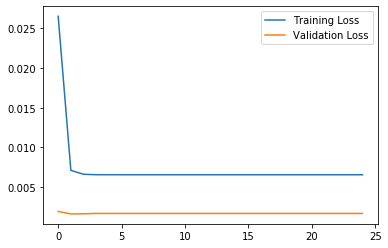

In [2133]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [2134]:
np.mean(history.history['loss'][10:]), np.mean(history.history['val_loss'][10:])

(0.006557715901484092, 0.0016853075940161943)

In [2135]:
# Scaler results
y_test_1 = y_test.copy()
prd_LSTM_FS_1buoy = model.predict(X_test[:,:,FS_order])

In [2136]:
# Reverse to original data
for target_order in range(len(target_feature)):
    prd_LSTM_FS_1buoy[:,:,target_order]=scalers['scaler_'+table.columns[target_feature[target_order]]].inverse_transform(prd_LSTM_FS_1buoy[:,:,target_order])
    
y_test_1[:,:,target_feature_FS] = scalers['scaler_'+table.columns[target_feature_FS]].inverse_transform(y_test_1[:,:,target_feature_FS])

Evaluate forecast of variables other than Dirp

In [2137]:
evaluate_forecasts(y_test_1[:,:,target_feature], prd_LSTM_FS_1buoy[:,:,0])

(array([0.10224263]),
 [0.047498607421866984,
  0.05171658952379824,
  0.06522091007628801,
  0.0771278802493506,
  0.08655944600550654,
  0.09558931237224963,
  0.10445272079675703,
  0.11297851104829879,
  0.12097718142596371,
  0.12861661907043595,
  0.13587734117337918,
  0.1427050188197363])

Evaluate forecast of Dirp

In [1916]:
# Reverse to original data
# for target_order in range(len(target_feature)):
#     y_test_1[:,:,target_feature[target_order]] = scalers['scaler_'+table.columns[target_feature[target_order]]].inverse_transform(y_test_1[:,:,target_feature[target_order]])


In [2009]:
target_feature_FS

18

In [2040]:
sinx = prd_LSTM_FS_1buoy[:,:,0].flatten()
cosx = prd_LSTM_FS_1buoy[:,:,1].flatten()

In [2052]:
Dirp1_reverse = np.array([return_degree(sinx[j],cosx[j]) for j in range(len(sinx))])
b = Dirp1_reverse.reshape(prd_LSTM_FS_1buoy[:,:,0].shape[0],prd_LSTM_FS_1buoy[:,:,0].shape[1])
b.shape

(1165, 12)

In [2053]:
a = y_test_1[:,:,target_feature_FS]
a.shape
# a[np.isnan(a)]

(1165, 12)

In [2054]:
# step = 1
for step in range(12):
#     print('Step_'+str(step+1),mean_absolute_error(a[:,step,:][~np.isnan(b[:,step,:])], b[:,step,:][~np.isnan(b[:,step,:])]))
    print('Step_'+str(step+1),cal_RMSE(a[:,step][~np.isnan(b[:,step])], b[:,step][~np.isnan(b[:,step])]))

Step_1 66.49433745963286
Step_2 18.88588262897387
Step_3 20.10987529734632
Step_4 22.773306215246304
Step_5 25.590622794986004
Step_6 25.240416624826835
Step_7 26.08481829578878
Step_8 25.652945507967953
Step_9 24.416237639660853
Step_10 23.956776028971838
Step_11 23.063652291849376
Step_12 23.398450942557762


In [2055]:
evaluate_forecasts(a, b)

(29.694490712697323,
 [66.49433745963286,
  18.88588262897387,
  20.10987529734632,
  22.773306215246304,
  25.590622794986004,
  25.240416624826835,
  26.08481829578878,
  25.652945507967953,
  24.416237639660853,
  23.956776028971838,
  23.063652291849376,
  23.398450942557762])

In [1959]:
evaluate_forecasts(a, b)

(18.506226670923382,
 [17.25219920816222,
  15.676021352179324,
  16.320339832161316,
  17.13469419750185,
  17.841872964473666,
  18.48098558084695,
  18.948753475159528,
  19.364806370084054,
  19.678476813802952,
  19.99088995243125,
  20.19265741517277,
  20.442261604202915])

In [2138]:
evaluate_forecasts(y_test_1[:,:,target_feature], 
                   prd_LSTM_FS_1buoy[:,:,0])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\displayhook.py:276: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


(array([0.10224263]),
 [0.047498607421866984,
  0.05171658952379824,
  0.06522091007628801,
  0.0771278802493506,
  0.08655944600550654,
  0.09558931237224963,
  0.10445272079675703,
  0.11297851104829879,
  0.12097718142596371,
  0.12861661907043595,
  0.13587734117337918,
  0.1427050188197363])

In [2139]:
from sklearn.metrics import mean_absolute_error
# for index,i in enumerate(train_df.columns[:7]):
#     print(i)
for j in range(1,n_future+1):
    print("LSTM half hr ",j,":","MAE: ",mean_absolute_error(y_test[:,j-1,target_feature],prd_LSTM_FS_1buoy[:,j-1,target_feature]),end=", ")
    print("LSTM half hr ",j,":","RMSE: ",cal_RMSE(y_test_1[:,j-1,target_feature],prd_LSTM_FS_1buoy[:,j-1,target_feature]),end=", ")
    print()


LSTM half hr  1 : MAE:  1.2183046283108971, LSTM half hr  1 : RMSE:  0.047498607421866984, 
LSTM half hr  2 : MAE:  1.234911644481516, LSTM half hr  2 : RMSE:  0.05171658952379824, 
LSTM half hr  3 : MAE:  1.2418604217506672, LSTM half hr  3 : RMSE:  0.06522091007628801, 
LSTM half hr  4 : MAE:  1.2465201458424455, LSTM half hr  4 : RMSE:  0.0771278802493506, 
LSTM half hr  5 : MAE:  1.2450427235184398, LSTM half hr  5 : RMSE:  0.08655944600550654, 
LSTM half hr  6 : MAE:  1.2431849627390597, LSTM half hr  6 : RMSE:  0.09558931237224963, 
LSTM half hr  7 : MAE:  1.2454499081628025, LSTM half hr  7 : RMSE:  0.10445272079675703, 
LSTM half hr  8 : MAE:  1.2495769688878002, LSTM half hr  8 : RMSE:  0.11297851104829879, 
LSTM half hr  9 : MAE:  1.2544148653717289, LSTM half hr  9 : RMSE:  0.12097718142596371, 
LSTM half hr  10 : MAE:  1.259181958007254, LSTM half hr  10 : RMSE:  0.12861661907043595, 
LSTM half hr  11 : MAE:  1.2635771177251698, LSTM half hr  11 : RMSE:  0.13587734117337918

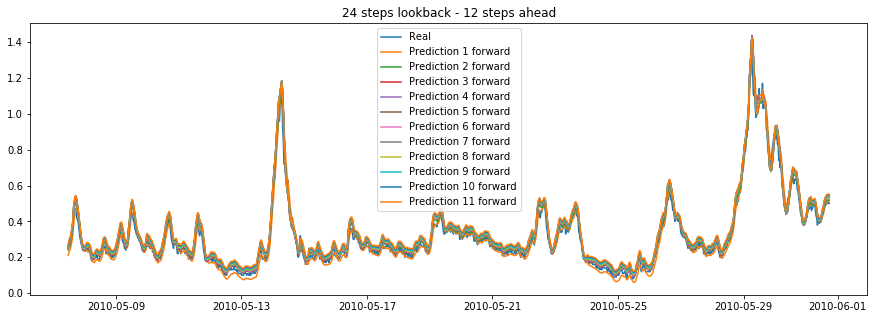

In [2227]:
plt.figure(figsize=(15,5))
plt.title('24 steps lookback - 12 steps ahead')

plt.plot(test_df.index[24-1:len(test_df)-12], test_df.iloc[24-1:len(test_df)-12,target_feature_FS],label='Real')
for i in range(1,n_future):
#     plt.subplot(6,1,i)
    
    plt.plot(test_df.index[24-1:len(test_df)-12], prd_LSTM_FS_1buoy[:,i-1,0], label='Prediction '+ str(i) + ' forward')
    plt.legend()
#     print(str(i)+' lookback RMSE: ',cal_RMSE(predict[:,i-1,0],test[12+i-1:len(test)-5+i-1,0]), 'R2: ',r2_score(predict[:,i-1,0],test[12+i-1:len(test)-5+i-1,0], multioutput='raw_values'))

    # plt.ylim(0,5)
plt.savefig('24-12_LSTM_1Hs.png',box_inches='tight')

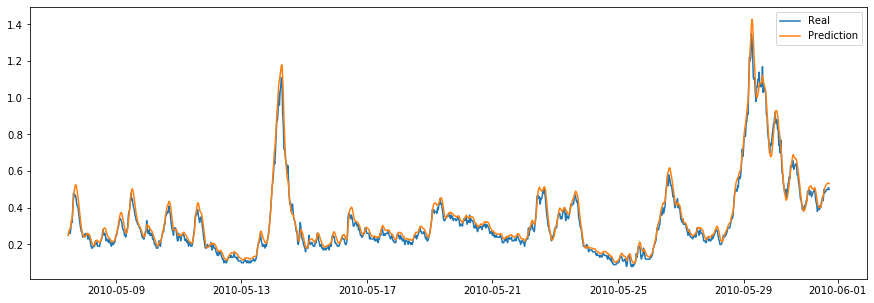

In [2229]:
i = 6 # future
plt.figure(figsize=(15,5))
# plt.plot(test.index[24+i-1:], y_test_1[:, 11,target_feature[0]],label='Real')
plt.plot(test_df.index[24-1:len(test)-12], test_df.iloc[24-1:len(test)-12,target_feature_FS],label='Real')
plt.plot(test_df.index[24-1:len(test)-12], prd_LSTM_FS_1buoy[:,i-1,0],label='Prediction')
plt.legend()

# Model Plot

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 200)               162400    
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 12, 200)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 12, 200)           320800    
_________________________________________________________________
time_distributed_20 (TimeDis (None, 12, 100)           20100     
_________________________________________________________________
time_distributed_21 (TimeDis (None, 12, 1)             101       
Total params: 503,401
Trainable params: 503,401
Non-trainable params: 0
_________________________________________________________________
None


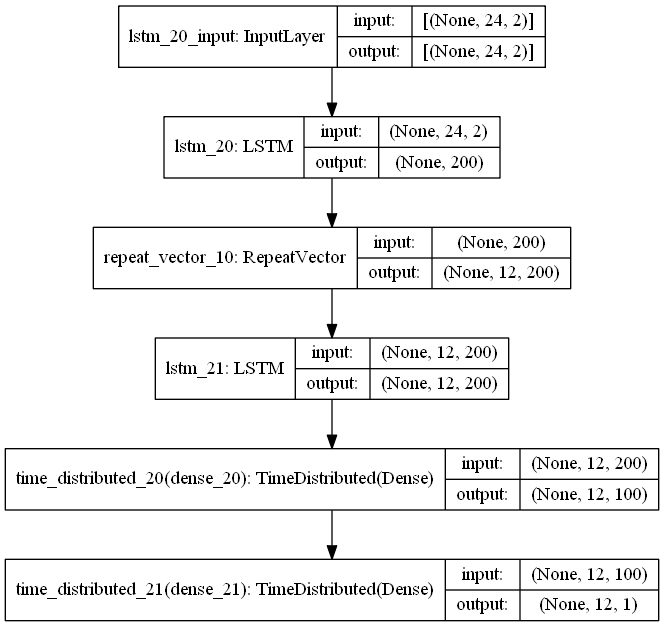

In [1472]:
model = build_model_LSTM_FS_1buoy(train, n_past, n_future, FS_order)
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True) # to_file=

In [1476]:
model = build_model_LSTM_FS_Dirp(train, n_past, n_future, FS_order)
print(model.summary())
# plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 200)               162400    
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 12, 200)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 12, 200)           320800    
_________________________________________________________________
time_distributed_24 (TimeDis (None, 12, 100)           20100     
_________________________________________________________________
time_distributed_25 (TimeDis (None, 12, 2)             202       
Total params: 503,502
Trainable params: 503,502
Non-trainable params: 0
_________________________________________________________________
None


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 24, 7)]      0                                            
__________________________________________________________________________________________________
lstm_88 (LSTM)                  [(None, 200), (None, 166400      input_32[0][0]                   
__________________________________________________________________________________________________
repeat_vector_41 (RepeatVector) (None, 12, 200)      0           lstm_88[0][0]                    
__________________________________________________________________________________________________
lstm_89 (LSTM)                  (None, 12, 200)      320800      repeat_vector_41[0][0]           
                                                                 lstm_88[0][1]             

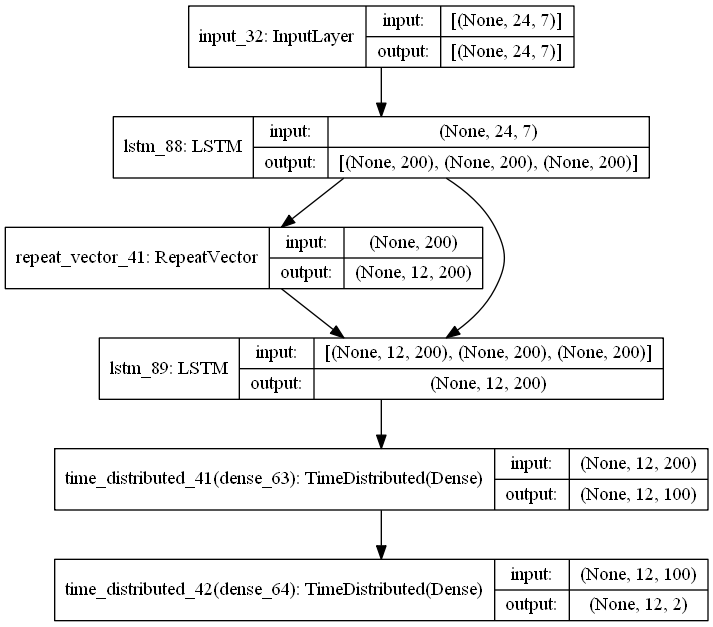

In [1991]:
model = build_model_StackedLSTM_FS_1buoy(train, n_past, n_future, FS_order)
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True) # to_file=

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 24, 7)]      0                                            
__________________________________________________________________________________________________
lstm_96 (LSTM)                  [(None, 24, 200), (N 166400      input_35[0][0]                   
__________________________________________________________________________________________________
lstm_97 (LSTM)                  [(None, 200), (None, 320800      lstm_96[0][0]                    
__________________________________________________________________________________________________
repeat_vector_44 (RepeatVector) (None, 12, 200)      0           lstm_97[0][0]                    
___________________________________________________________________________________________

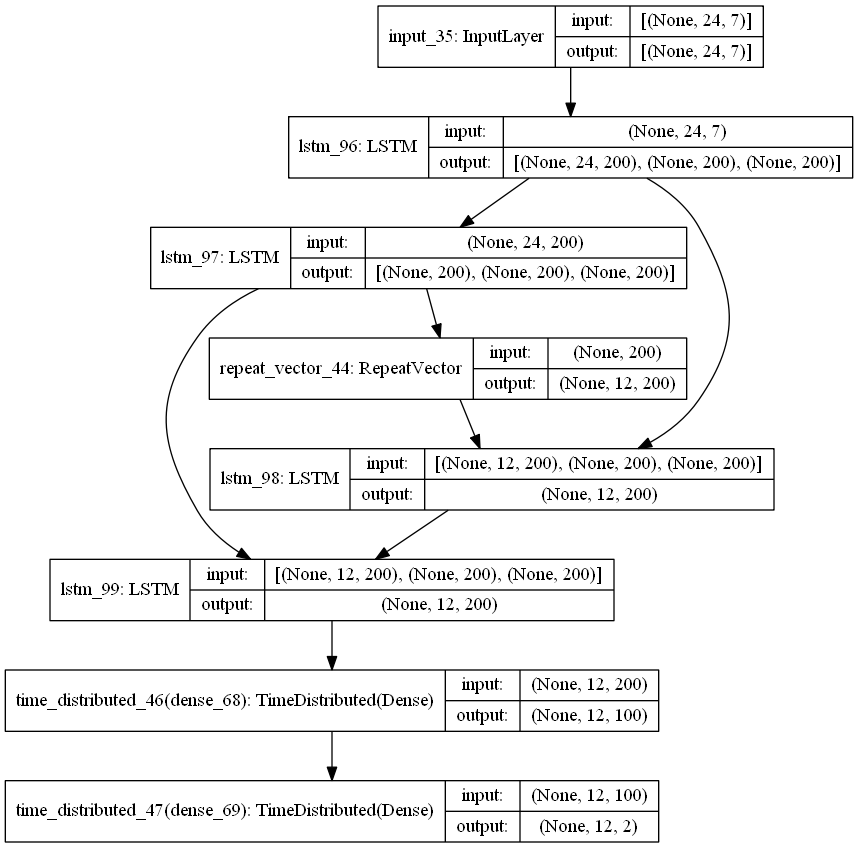

In [1996]:
model = build_model_2StackedLSTM(train, n_past, n_future, FS_order)
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True) # to_file=

### Attention
https://www.kaggle.com/eladwar/conditional-rnn#What-do-I-do-to-get-everything-ready-for-a-categorical-RNN  
Github: https://github.com/philipperemy/cond_rnn

In [2000]:
# 10 stations
# 365 days
# 3 continuous variables A and B => C is target.
# 2 conditions dim=5 and dim=1. First cond is one-hot. Second is continuous.
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from cond_rnn import ConditionalRNN

stations = 10  # 10 stations.
time_steps = 365  # 365 days.
continuous_variables_per_station = 3  # A,B,C where C is the target.
condition_variables_per_station = 2  # 2 variables of dim 5 and 1.
condition_dim_1 = 5
condition_dim_2 = 1

np.random.seed(123)
continuous_data = np.random.uniform(size=(stations, time_steps, continuous_variables_per_station))
condition_data_1 = np.zeros(shape=(stations, condition_dim_1))
condition_data_1[:, 0] = 1  # dummy.
condition_data_2 = np.random.uniform(size=(stations, condition_dim_2))

window = 50  # we split series in 50 days (look-back window)

x, y, c1, c2 = [], [], [], []
for i in range(window, continuous_data.shape[1]):
    x.append(continuous_data[:, i - window:i])
    y.append(continuous_data[:, i])
    c1.append(condition_data_1)  # just replicate.
    c2.append(condition_data_2)  # just replicate.

# now we have (batch_dim, station_dim, time_steps, input_dim).
x = np.array(x)
y = np.array(y)
c1 = np.array(c1)
c2 = np.array(c2)

print(x.shape, y.shape, c1.shape, c2.shape)

# let's collapse the station_dim in the batch_dim.
x = np.reshape(x, [-1, window, x.shape[-1]])
y = np.reshape(y, [-1, y.shape[-1]])
c1 = np.reshape(c1, [-1, c1.shape[-1]])
c2 = np.reshape(c2, [-1, c2.shape[-1]])

print(x.shape, y.shape, c1.shape, c2.shape)

model = Sequential(layers=[
    ConditionalRNN(10, cell='GRU'),  # num_cells = 10
    Dense(units=1, activation='linear')  # regression problem.
])

model.compile(optimizer='adam', loss='mse')
model.fit(x=[x, c1, c2], y=y, epochs=2, validation_split=0.2)

(315, 10, 50, 3) (315, 10, 3) (315, 10, 5) (315, 10, 1)
(3150, 50, 3) (3150, 3) (3150, 5) (3150, 1)
Epoch 1/2
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
75/79 [===========================>..] - ETA: 0s - loss: 0.3266- ETA: 0s - loss: 0.343WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'tuple'> input: (<tf.Tensor 'IteratorGetNext:0' shape=(None, 50, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 5) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1) dtype=float32>)
Consider rewriting this model with the Functional API.
79/79 [==============================] - 2s 16ms/step - loss: 0.3151 - val_loss: 0.0866
Epoch 2/2
79/79 [==============================] - 1s 12ms/step - loss: 0.0886 - val_loss: 0.0852


In [2003]:
print(model.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conditional_rnn (Conditional multiple                  0 (unused)
_________________________________________________________________
dense_82 (Dense)             multiple                  11        
Total params: 544
Trainable params: 544
Non-trainable params: 0
_________________________________________________________________
None


# Multivariate Multi-step Time Series - End
Stacked LSTM Seq2Seq Autoencoder in Tensorflow 2.0/Keras
code from the following
https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 200)               166400    
_________________________________________________________________
repeat_vector_19 (RepeatVect (None, 12, 200)           0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 12, 200)           320800    
_________________________________________________________________
time_distributed_35 (TimeDis (None, 12, 100)           20100     
_________________________________________________________________
time_distributed_36 (TimeDis (None, 12, 1)             101       
Total params: 507,401
Trainable params: 507,401
Non-trainable params: 0
_________________________________________________________________
None


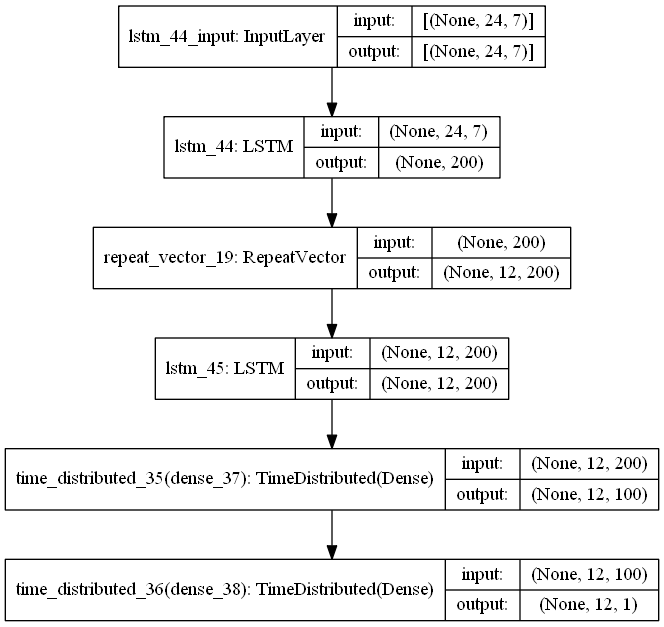

In [1966]:
n_features_input = 7
n_features_output = 1

model_test = Sequential()
model_test.add(LSTM(200, activation='relu', input_shape=(n_past, n_features_input)))
model_test.add(RepeatVector(n_future))
model_test.add(LSTM(200, activation='relu', return_sequences=True))
model_test.add(TimeDistributed(Dense(100, activation='relu')))
model_test.add(TimeDistributed(Dense(n_features_output)))

print(model_test.summary())
plot_model(model_test, show_shapes=True, show_layer_names=True) # to_file=

In [1992]:
encoder_inputs = Input(shape=(n_past, n_features_input))

encoder_l1 = LSTM(200, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
    #
decoder_inputs = RepeatVector(n_future)(encoder_outputs1[0])
    #
decoder_l1 = LSTM(200, return_sequences=True)(decoder_inputs, initial_state=encoder_states1)
decoder_outputs1 = TimeDistributed(tf.keras.layers.Dense(n_features_output))(decoder_l1)
    #
attn_layer = AttentionLayer(name='attention_layer')
attn_out, atten_states = atten_layer([encoder_outputs1, decoder_outputs1])
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])

model_test = tf.keras.models.Model(encoder_inputs, decoder_outputs1)

print(model_test.summary())
plot_model(model_test, show_shapes=True, show_layer_names=True) # to_file=

NameError: name 'AttentionLayer' is not defined

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_41 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     64000       input_40[0][0]                   
                                                                 input_41[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, None, 100)    25700       embedding_3[0][0]         

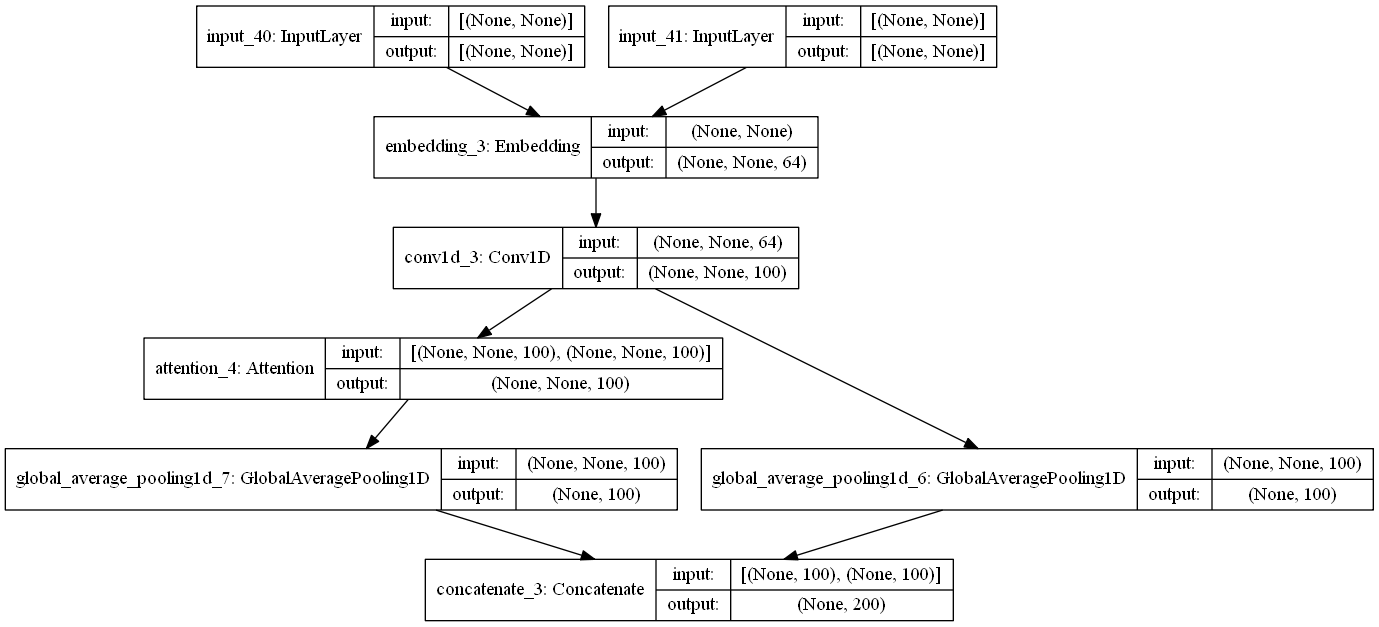

In [1999]:
# Variable-length int sequences.
query_input = tf.keras.Input(shape=(None,), dtype='int32')
value_input = tf.keras.Input(shape=(None,), dtype='int32')

# Embedding lookup.
token_embedding = tf.keras.layers.Embedding(input_dim=1000, output_dim=64)
# Query embeddings of shape [batch_size, Tq, dimension].
query_embeddings = token_embedding(query_input)
# Value embeddings of shape [batch_size, Tv, dimension].
value_embeddings = token_embedding(value_input)

# CNN layer.
cnn_layer = tf.keras.layers.Conv1D(
    filters=100,
    kernel_size=4,
    # Use 'same' padding so outputs have the same shape as inputs.
    padding='same')
# Query encoding of shape [batch_size, Tq, filters].
query_seq_encoding = cnn_layer(query_embeddings)
# Value encoding of shape [batch_size, Tv, filters].
value_seq_encoding = cnn_layer(value_embeddings)

# Query-value attention of shape [batch_size, Tq, filters].
query_value_attention_seq = tf.keras.layers.Attention()(
    [query_seq_encoding, value_seq_encoding])

# Reduce over the sequence axis to produce encodings of shape
# [batch_size, filters].
query_encoding = tf.keras.layers.GlobalAveragePooling1D()(
    query_seq_encoding)
query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
    query_value_attention_seq)

# Concatenate query and document encodings to produce a DNN input layer.
input_layer = tf.keras.layers.Concatenate()(
    [query_encoding, query_value_attention])

model_test = tf.keras.models.Model([query_input,value_input], input_layer)

print(model_test.summary())
plot_model(model_test, show_shapes=True, show_layer_names=True) # to_file=

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 24, 7)]           0         
_________________________________________________________________
lstm_84 (LSTM)               (None, 200)               166400    
_________________________________________________________________
repeat_vector_39 (RepeatVect (None, 12, 200)           0         
_________________________________________________________________
lstm_85 (LSTM)               (None, 12, 200)           320800    
_________________________________________________________________
time_distributed_38 (TimeDis (None, 12, 100)           20100     
_________________________________________________________________
time_distributed_39 (TimeDis (None, 12, 1)             101       
Total params: 507,401
Trainable params: 507,401
Non-trainable params: 0
_____________________________________________________

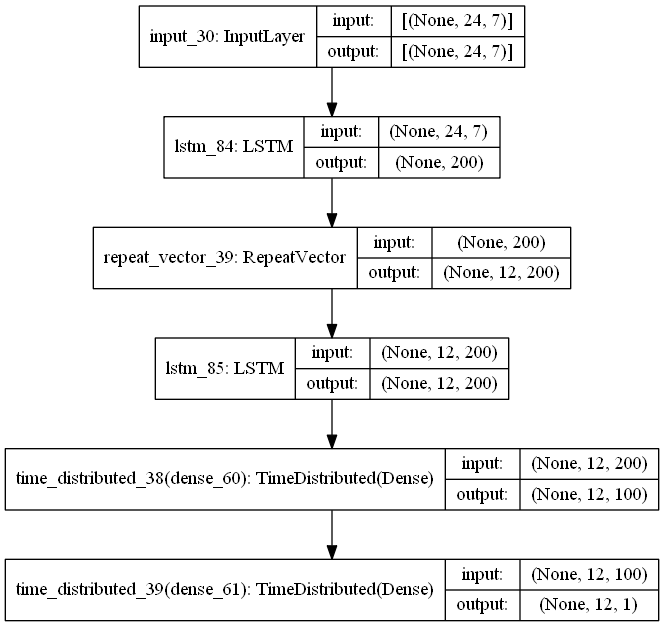

In [1988]:

i = Input(shape=((n_past, n_features_input,)))
encoded = LSTM(200)(i)
decoded = RepeatVector(n_future)(encoded)
decoded = LSTM(200, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(100, activation='relu'))(decoded)
decoded = TimeDistributed(Dense(1))(decoded)

model_test = Model(i, decoded)
print(model_test.summary())
plot_model(model_test, show_shapes=True, show_layer_names=True) # to_file=

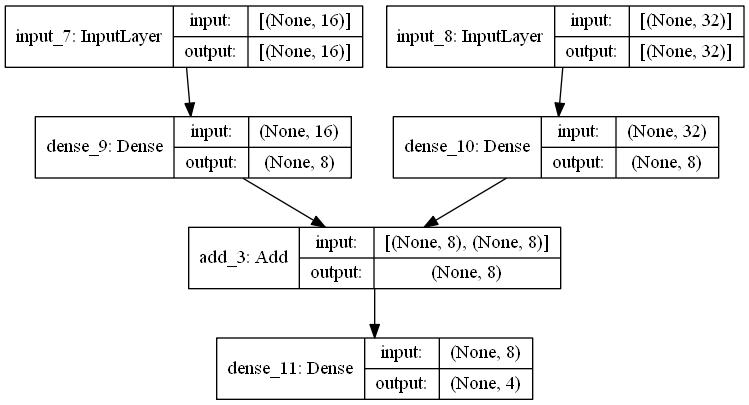

In [33]:
import keras

input1 = keras.layers.Input(shape=(16,)) 
x1 = keras.layers.Dense(8, activation='relu')(input1) 
input2 = keras.layers.Input(shape=(32,)) 
x2 = keras.layers.Dense(8, activation='relu')(input2) 
added = keras.layers.add([x1, x2]) 
out = keras.layers.Dense(4)(added) 
model = keras.models.Model(inputs=[input1, input2], outputs=out)
plot_model(model, show_shapes=True, show_layer_names=True)

In [32]:
# CNN-LSTM

cnn = Sequential()
# define CNN model
cnn.add(Conv2D(1, (2,2), activation='relu', padding='same', input_shape=(4,4,1)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
# define LSTM model
model = Sequential()
model.add(TimeDistributed(cnn))
model.add(LSTM(200, activation='relu', input_shape=(12, 7)))
model.add(Dense(100, activation='relu'))

print(model.summary())
# plot_model(model, show_shapes=True, show_layer_names=True)

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [105]:
# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]
np.argmax([1,3,4,5,6,24,23])

5

In [91]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam

latent_dim = 50 # LSTM hidden units
dropout = .20 

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(21, 8)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(21, 5)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [1962]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam

latent_dim = 50 # LSTM hidden units
dropout = .20 

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(21, 8)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(21, 5)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# attn_layer = Attention()([encoder_outputs, decoder_outputs])
# attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

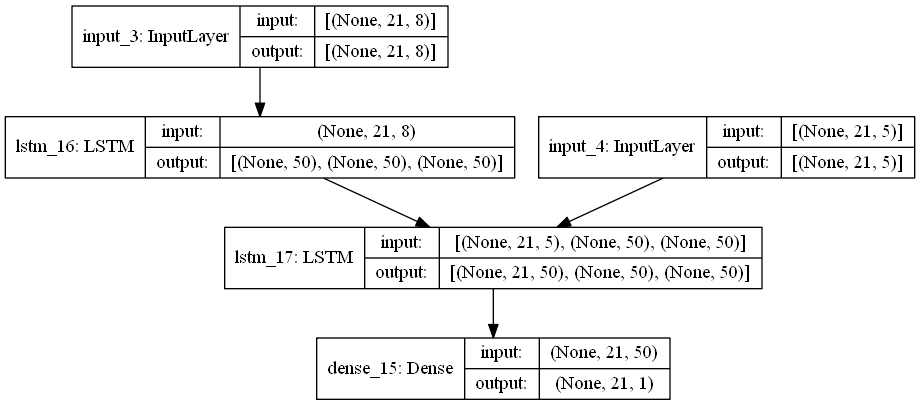

In [41]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
summarize_scores('lstm', score, scores)

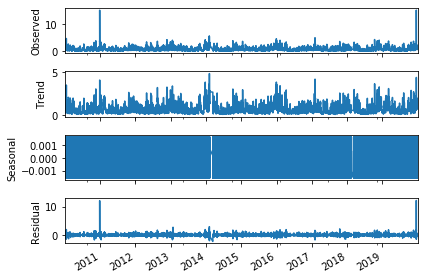

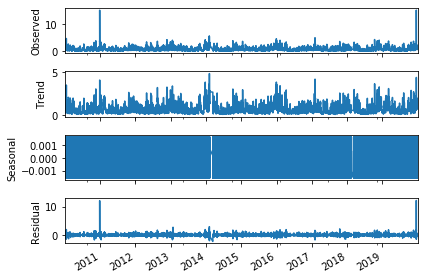

In [178]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(table.dropna(axis=0)['Wave Height (m)'].iloc[:,0], freq=24, two_sided=False)
decomposition.plot()

In [181]:
from sklearn.metrics import r2_score

In [102]:
table.resample('h').mean().dropna(axis=0)

,Wave Height (m),Peak Direction (degrees),Tz (s),Tpeak (s),Wave Height (m),Peak Direction (degrees),Tz (s),Tpeak (s),Wave Height (m),Peak Direction (degrees),Tz (s),Tpeak (s)
2010-01-01 13:00:00,0.470,188.0,6.50,12.50,0.620,212.0,6.30,12.50,0.620,338.0,4.40,5.00
2010-01-01 14:00:00,0.460,188.0,6.45,11.80,0.625,216.0,6.90,12.90,0.605,338.5,4.40,5.15
2010-01-01 15:00:00,0.495,187.5,6.30,11.80,0.705,216.5,7.75,11.80,0.665,332.5,4.40,5.00
2010-01-01 16:00:00,0.495,188.5,6.45,11.10,0.655,221.5,7.45,10.80,0.640,337.5,4.10,5.05
2010-01-01 17:00:00,0.510,189.0,6.45,11.45,0.675,219.0,7.75,11.10,0.600,289.0,4.00,7.85
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 18:00:00,0.700,178.0,4.25,4.90,0.775,208.0,3.90,11.10,1.015,270.5,7.00,10.80
2019-12-31 19:00:00,0.680,172.0,3.95,4.60,0.790,210.5,4.00,10.55,1.085,268.0,6.95,11.15
2019-12-31 20:00:00,0.670,181.5,4.15,4.90,0.815,211.5,3.90,10.50,0.955,268.0,6.60,11.15
2019-12-31 21:00:00,0.640,169.5,4.35,4.80,0.875,211.0,3.90,10.25,0.925,273.5,6.50,11.45


In [93]:
import tensorflow as tf

fft = tf.signal.rfft(Hs)
f_per_dataset = np.arange(0, fft.shape.as_list()[0])

n_samples_h = len(Hs)
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
# plt.ylim(0, 60000)
plt.xlim([0.1, max(plt.xlim())])
plt.title('FFT for wind speed (station A, upper left satellite)')
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
plt.savefig('FFT_sat_windspeed_stationA.pdf')

NotImplementedError: Cannot convert a symbolic Tensor (rfft_7:0) to a numpy array.

In [70]:
fft

<tf.Tensor 'rfft_5:0' shape=(43818,) dtype=complex64>

In [76]:
yy = np.fft.fft(Hs)
yf =np.abs(np.fft.fft(Hs))
yf1 = np.abs(np.fft.fft(Hs))/(len(Hs)/2)
yf2 = yf1[range(int(len(Hs)/2))]

In [60]:
f_per_dataset = np.arange(0, len(yf2))

ValueError: x and y must have same first dimension, but have shapes (619,) and (618,)

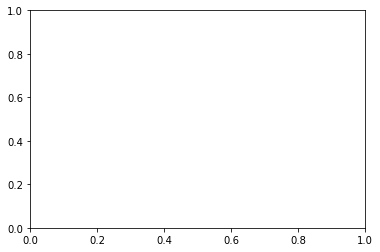

In [79]:
n_samples_h = len(Hs)
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, yf2)
plt.xscale('log')
# plt.ylim(0, 60000)
# plt.xlim([0.1, max(plt.xlim())])
plt.title('FFT for wind speed (station A, upper left satellite)')
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
plt.savefig('FFT_sat_windspeed_stationA.pdf')

Text(0, 0.5, '|Y(freq)|')

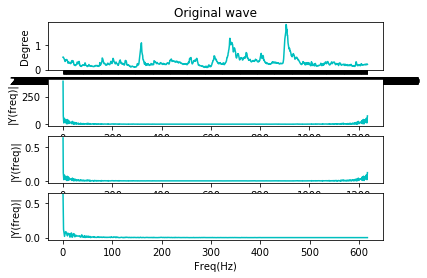

In [81]:
y = Hs
fig, ax = plt.subplots(4,1)

ax[0].plot(y,color='c', label='Roll')
ax[0].set_xlabel('Second')
ax[0].set_ylabel('Degree')
ax[0].set_title('Original wave')

ax[1].plot(yf,color='c', label='Roll')
ax[1].set_xlabel('Freq(Hz)')
ax[1].set_ylabel('|Y(freq)|')
# ax[1].set_title('FFT of Mixed wave(two sides frequency range)',fontsize=7,color='#7A378B')

ax[2].plot(yf1,color='c', label='Roll')
ax[2].set_xlabel('Freq(Hz)')
ax[2].set_ylabel('|Y(freq)|')
# ax[1].set_title('FFT of Mixed wave(two sides frequency range)',fontsize=7,color='#7A378B')

ax[3].plot(yf2,color='c', label='Roll')
ax[3].set_xlabel('Freq(Hz)')
ax[3].set_ylabel('|Y(freq)|')

([<matplotlib.axis.XTick at 0x1f684de4860>,
 <a list of 2 Text xticklabel objects>)

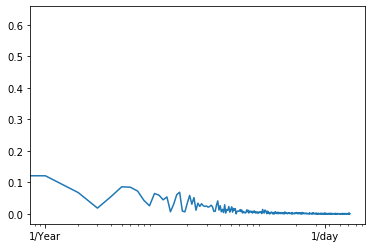

In [92]:
plt.plot(yf2)
plt.xscale('log')
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])

In [87]:
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
len(f_per_year)

619

In [90]:
yf2

array([6.27540452e-01, 1.21072659e-01, 6.77452310e-02, 1.84789031e-02,
       5.52642099e-02, 8.60525602e-02, 8.49401155e-02, 7.26414996e-02,
       4.30049927e-02, 2.58773955e-02, 6.48817185e-02, 5.95923167e-02,
       4.48377445e-02, 5.39805752e-02, 6.88552621e-03, 3.10820987e-02,
       6.13142431e-02, 6.88879632e-02, 9.13748721e-03, 6.67372115e-03,
       3.47254641e-02, 5.88717819e-02, 3.08465478e-02, 5.20484016e-02,
       1.17956840e-02, 3.41489678e-02, 2.38932337e-02, 3.24579733e-02,
       2.58125031e-02, 2.38099239e-02, 2.52989332e-02, 2.14433726e-02,
       2.32815482e-02, 2.76508042e-02, 2.27318902e-02, 8.28978870e-03,
       8.31345149e-03, 2.79388318e-02, 4.13341332e-02, 1.21893031e-02,
       2.63198452e-02, 6.62484410e-03, 1.46641095e-02, 4.25113865e-03,
       2.93330973e-02, 2.64971685e-03, 1.38442163e-02, 1.14837761e-02,
       2.36716753e-02, 5.74272464e-03, 1.36984635e-02, 2.25411419e-02,
       5.68449674e-03, 1.72786721e-02, 1.16941004e-02, 1.67469249e-02,
      

ValueError: x and y must have same first dimension, but have shapes (619,) and (618,)

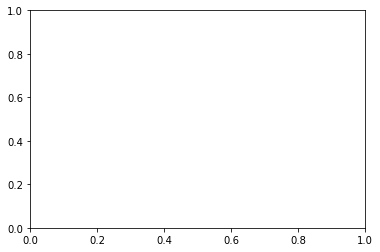

In [83]:
n_samples_h = len(Hs)
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, yf2)
plt.xscale('log')
# plt.ylim(0, 60000)
# plt.xlim([0.1, max(plt.xlim())])
plt.title('FFT for wind speed (station A, upper left satellite)')
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
plt.savefig('FFT_sat_windspeed_stationA.pdf')